In [143]:
import pandas as pd
import numpy as np
from collections import OrderedDict
from dataclasses import dataclass, field

import json

In [95]:
df = pd.read_csv("./data/example_account.csv")

In [96]:
def extract_key(dict_keys, candidates):
    return [string for string in list(dict_keys) if string in candidates][0]

In [242]:
df.query("EVENT_NAME == 'Repay'")['DECODED_LOG'].iloc[0]

'{"amount":50029328,"repayer":"0xe47d5cc33517d5b8433ff249efe094b989989acc","reserve":"0x056fd409e1d7a124bd7017459dfea2f387b6d5cd","user":"0xe47d5cc33517d5b8433ff249efe094b989989acc"}'

In [221]:
token_dict = {'0xdac17f958d2ee523a2206206994597c13d831ec7': {'symbol':'USDT', 'decimals': 6},
              '0x0000000000085d4780b73119b644ae5ecd22b376': {'symbol':'TUSD', 'decimals': 18},
              '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': {'symbol': 'USDC', 'decimals': 6},
              '0x6b175474e89094c44da98b954eedeac495271d0f': {'symbol': 'DAI', 'decimals': 18},
              '0x056fd409e1d7a124bd7017459dfea2f387b6d5cd': {'symbol': 'GUSD', 'decimals': 18},
              '0x57ab1ec28d129707052df4df418d58a2d46d5f51': {'symbol': 'sUSD', 'decimals': 18}}

In [220]:
df.SYMBOL.value_counts()

PORTX               1495
SAFE                1030
WORM                 997
IRON                 997
WBTC                 949
WETH                 811
USDC                 743
CNV                  697
BLUR                 693
USDT                 655
L3T                  475
DAI                  406
aWETH                295
aWBTC                293
SLP                  226
UNI-V2               184
aUSDT                127
stableDebtUSDC       118
TUSD                 110
aUSDC                107
stableDebtUSDT        96
aDAI                  52
stableDebtDAI         52
aETH                  52
BNT                   49
BPT                   45
aTUSD                 29
sUSD                  28
GUSD                  23
CRO-SWAP              16
stableDebtTUSD        12
variableDebtTUSD       8
variableDebtSUSD       8
aSUSD                  8
mUSD                   6
1LP-ETH-WBTC           6
1LP-ETH-DAI            6
1LP-ETH-USDC           6
3Crv                   5
aLINK                  5


In [265]:
@dataclass
class Token():
    '''
    Contains total information on token history
    '''
    
    token_symbol: str
    balance: OrderedDict = field(default_factory=OrderedDict) # Key is timestamp, value is balance
    debt: OrderedDict = field(default_factory=OrderedDict)
    tx_history: list = field(default_factory=list)

    def _get_previous_balance(self) -> float:
        '''Returns the previous balance'''
        
        if len(self.balance) == 0:
            balance = 0
        else:
            last_tx = next(reversed(OrderedDict(self.balance)))
            balance = self.balance[last_tx]
            
        return balance
    
    def _get_previous_debt(self) -> float:
        if len(self.debt) == 0:
            debt = 0
        else:
            last_tx = next(reversed(OrderedDict(self.debt)))
            debt = self.debt[last_tx]
        
        return debt
    
    def update_balance(self, timestamp, amount):
        '''
        
        '''
        self.balance[timestamp] = self._get_previous_balance() + amount
    
    def update_debt(self, timestamp, amount):
        self.debt[timestamp] = self._get_previous_debt() + amount

class Wallet():
    ''''
    Contains all the tokens
    '''
    
    tokens: dict = {}
    
    
    def update_token(self, token_symbol, timestamp, amount, tx_type):
        
        if token_symbol not in self.tokens.keys():
            self._add_token(token_symbol)
            
        token = self.get_token(token_symbol)
        
        if tx_type == 'Transfer':
            token.update_balance(timestamp, amount)
        
        elif tx_type == 'Borrow':
            token.update_debt(timestamp, amount)
        
        elif tx_type == 'Repay':
            token.update_debt(timestamp, -amount)
    
    def get_token(self, token_symbol):
        return self.tokens.get(token_symbol)
    
    def _add_token(self, token_symbol):
        
        self.tokens[token_symbol] = Token(token_symbol=token_symbol) 
    
        

In [266]:
wallet = Wallet()

for index, row in df.iterrows():
    event_name = row['EVENT_NAME']
    block_time = row['BLOCK_TIMESTAMP']

    if row['DECODED_LOG'] is not np.nan:
        decoded_log = json.loads(row['DECODED_LOG'])

    if event_name == 'Transfer':
        contract_name = row['CONTRACT_NAME']
        decimals = row['DECIMALS']
        symbol = row['SYMBOL']
        
        sender = decoded_log[extract_key(decoded_log.keys(), ['from', '_from', 'src'])]
        receiver = decoded_log[extract_key(decoded_log.keys(), ['_to', 'to', 'dst'])]
        amount = decoded_log[extract_key(decoded_log.keys(), ['_value', '_amount', 'amount', 'value', 'wad'])]

        #print(sender, receiver, contract_name, float(amount)/10**decimals)
        
        if sender == '0xe47d5cc33517d5b8433ff249efe094b989989acc':
            wallet.update_token(symbol, block_time, -float(amount)/10**decimals, event_name)
        elif receiver == '0xe47d5cc33517d5b8433ff249efe094b989989acc':
            wallet.update_token(symbol, block_time, float(amount)/10**decimals, event_name)

    
    elif event_name == 'Swap':
        pass        
    
    elif event_name == 'Borrow' or event_name == 'Repay':
        borrow_amount = decoded_log[extract_key(decoded_log.keys(), ['amount', '_amount', '_amountMinusFees'])]
        token_addr = decoded_log[extract_key(decoded_log.keys(), ['reserve', '_reserve'])]
        symbol = token_dict[token_addr]['symbol']
        decimals = token_dict[token_addr]['decimals']

        wallet.update_token(symbol, block_time, float(amount)/10**decimals, event_name)

        
     

In [260]:
df.query("BLOCK_TIMESTAMP == '2021-02-27 14:53:10.000'")['DECODED_LOG'].iloc[-1]

'{"amount":11730880355,"borrowRate":"88840659508875858206044990","borrowRateMode":1,"onBehalfOf":"0xe47d5cc33517d5b8433ff249efe094b989989acc","referral":0,"reserve":"0xdac17f958d2ee523a2206206994597c13d831ec7","user":"0xe47d5cc33517d5b8433ff249efe094b989989acc"}'

In [267]:
wallet.get_token('USDT').debt

OrderedDict([('2021-02-27 14:53:10.000', 11730.880355),
             ('2021-02-27 22:13:43.000', 20111.324961),
             ('2021-02-27 22:38:54.000', 27604.8704),
             ('2021-02-27 22:50:34.000', 34847.830987),
             ('2021-03-03 03:37:11.000', 3034847.830987),
             ('2021-03-05 03:36:59.000', 4078743.084952),
             ('2021-03-06 13:57:40.000', 5405412.929059),
             ('2021-03-09 15:33:31.000', 6405412.929059),
             ('2021-03-09 17:33:51.000', 7405412.929059),
             ('2021-03-10 00:26:19.000', 8405412.929058999),
             ('2021-03-19 22:50:08.000', 9405412.929058999),
             ('2021-03-26 17:00:19.000', 9905412.929058999),
             ('2021-03-26 22:22:21.000', 10505412.929058999),
             ('2021-03-28 18:22:29.000', 11005412.929058999),
             ('2021-04-06 02:22:47.000', 12005412.929058999),
             ('2021-04-07 14:24:10.000', 12222692.403537),
             ('2021-04-08 14:48:58.000', 13222692.403537),
 

<Axes: xlabel='variable'>

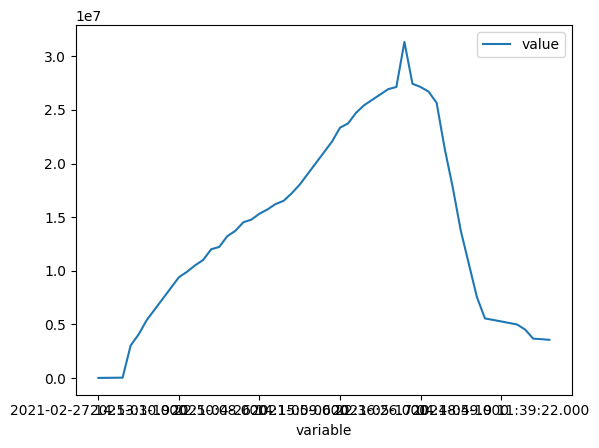

In [268]:
pd.DataFrame(dict(wallet.get_token('USDT').debt), index = [0]).melt().plot(x='variable', y='value')

In [251]:
df.query("EVENT_NAME == 'Repay'")

,BLOCK_NUMBER,EVENT_INDEX,BLOCK_TIMESTAMP,TX_HASH,CONTRACT_ADDRESS,CONTRACT_NAME,DECIMALS,SYMBOL,EVENT_NAME,DECODED_LOG,FROM_ADDRESS,TO_ADDRESS,ETH_VALUE,TX_FEE,TX_STATUS
1352,12037595,186.0,2021-03-14 15:49:11.000,0x1b8a564a7480cd13e000bf26a4f8b6c7fc59039b2658...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":50029328,""repayer"":""0xe47d5cc33517d5...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.030743,SUCCESS
5333,12449857,121.0,2021-05-17 04:45:13.000,0x5866baea2be3109786d0ce5745176008333f96bbdd88...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":3900000000000,""repayer"":""0xe47d5cc33...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.047777,SUCCESS
5337,12449871,212.0,2021-05-17 04:48:49.000,0xd5d3b96764bcac9d3cd4e3ff2c8606d991c452128da5...,0x398ec7346dcd622edc5ae82352f02be94c62d119,NaN,NaN,NaN,Repay,"{""_amountMinusFees"":299999586889,""_borrowBalan...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x398ec7346dcd622edc5ae82352f02be94c62d119,0.0,0.031179,SUCCESS
5370,12457179,57.0,2021-05-18 08:02:41.000,0x9d94d672f8c05789a34550c339479c61e84a0f4da429...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":433668243437,""repayer"":""0xe47d5cc335...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.021672,SUCCESS
5430,12457225,48.0,2021-05-18 08:11:44.000,0x8be5978e6a1b1183d5f71c16d7e87d296092a7544d37...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":1041097959013,""repayer"":""0xe47d5cc33...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.017289,SUCCESS
5508,12461074,461.0,2021-05-18 22:30:03.000,0x41d3574f1469479b6ac56a408835ba56689e437a492b...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":4262065735057,""repayer"":""0xe47d5cc33...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.022898,SUCCESS
5635,12461206,262.0,2021-05-18 22:59:23.000,0xea8b37cf62581029656cf6e38f16cc8baed57915c281...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":3615263506210,""repayer"":""0xe47d5cc33...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.022898,SUCCESS
5755,12462383,123.0,2021-05-19 03:16:14.000,0x0cae8da6f5ba41e1876637c15831399d577b7854f748...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":4042743897188,""repayer"":""0xe47d5cc33...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.043538,SUCCESS
5823,12462448,318.0,2021-05-19 03:32:47.000,0x70ac6ea677380dc6a4916a6ae21dd2ae22a5768b9345...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":3096190580414,""repayer"":""0xe47d5cc33...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.036137,SUCCESS
5926,12462546,251.0,2021-05-19 03:55:57.000,0x232efc6818830c3a82fe9a681be3752fa6429d74899e...,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,NaN,NaN,NaN,Repay,"{""amount"":3085217365300,""repayer"":""0xe47d5cc33...",0xe47d5cc33517d5b8433ff249efe094b989989acc,0x7d2768de32b0b80b7a3454c06bdac94a69ddc7a9,0.0,0.030683,SUCCESS
